<a href="https://colab.research.google.com/github/sidrocks/Digital-Safety-Monitor/blob/main/TSAI_ERAV4_Session4Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset

In [28]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [98]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [99]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [100]:
# Create a subset of the dataset with only 25,000 samples
subset_indices = list(range(25000))  # Select the first 25,000 indices
subset_indices_test = list(range(10000))
mnist_trainsubset = Subset(train_data, subset_indices)
mnist_testsubset = Subset(test_data, subset_indices_test)

In [110]:
#batch_size = 512
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

#test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
test_loader = torch.utils.data.DataLoader(mnist_testsubset, **kwargs)
train_loader = torch.utils.data.DataLoader(mnist_trainsubset, **kwargs)

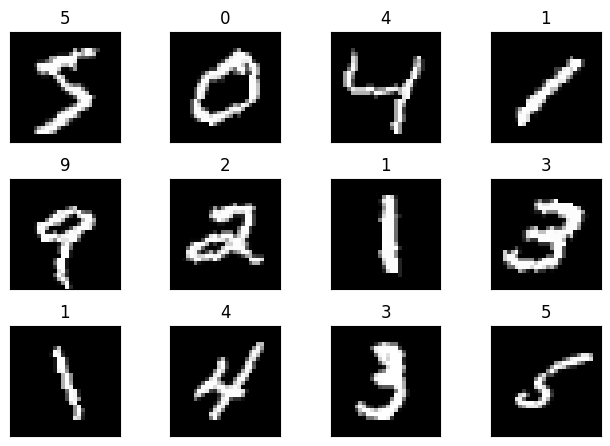

In [111]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [121]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=3)
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3)
        self.fc1 = nn.Linear(24*5*5,32)
        self.fc2 = nn.Linear(32, 10)

        #self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        #self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        #self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        #self.fc1 = nn.Linear(320, 50)
        #self.fc1 = nn.Linear(4096, 50)
        #self.fc1 = nn.Linear(25600, 50)
        #self.fc2 = nn.Linear(50, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))      # 12x26x26
        x = F.max_pool2d(x, 2)         # 12x13x13
        x = F.relu(self.conv2(x))      # 24x11x11
        x = F.max_pool2d(x, 2)         # 24x5x5
        x = x.view(-1, 24*5*5)         # 600 Flatten


        #x = F.relu(self.conv1(x), 2)
        #x = F.relu(F.max_pool2d(self.conv2(x),2))
        #x = F.relu(self.conv3(x), 2)
        #x = F.relu(F.max_pool2d(self.conv4(x), 2))
        #x = x.view(-1, 320)
        #x = x.view(-1, 4096)
        #x = x.view(-1, 25600)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return x

In [113]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [114]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            #test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [119]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [127]:
model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=0.011, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.002)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 1

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  #scheduler.step()

Epoch 1


Train: Loss=0.2322 Batch_id=195 Accuracy=84.55: 100%|██████████| 196/196 [00:08<00:00, 23.47it/s]


Test set: Average loss: 0.0009, Accuracy: 9670/10000 (96.70%)



Text(0.5, 1.0, 'Test Accuracy')

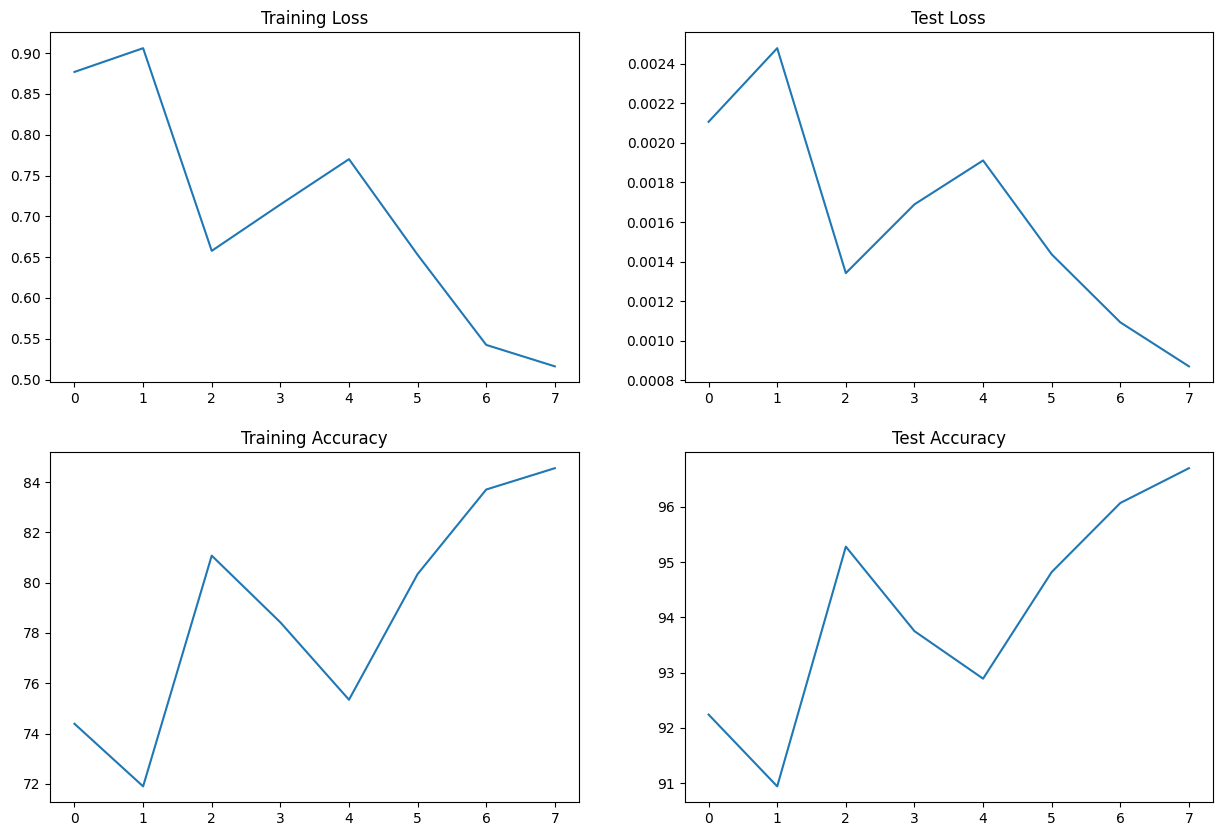

In [128]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [129]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             120
            Conv2d-2           [-1, 24, 11, 11]           2,616
            Linear-3                   [-1, 32]          19,232
            Linear-4                   [-1, 10]             330
Total params: 22,298
Trainable params: 22,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.09
Estimated Total Size (MB): 0.17
----------------------------------------------------------------
